In this notebook we explore how to implement black-box variational inference (bvi). The technique is general and especially bound to one introduced in [Black Box Variational Inference, R. Ranganath, et al.](https://arxiv.org/abs/1401.0118). From now on we will use BVI to refer to variational inference methods that can work on any latent models without specific model-based derivation.

# How it works

Probabilistic models with latent variables has various applications in machine learning. Latent variables models allows us to reason about the hidden structure among latent variables given data. The main problem of working with these models is to infer posterior distribution of latent variables. This allows us to say something about latent variables. Unforutnately to compute the posterior distribution is intractable. This forces practitioers to resort to approximate methods.

There are two approximation scheme MCMC and Variational Inference. Variational Inference cast the posterior approximiation into an optimization problem. This allows it to scale with big dataset. On the other hand, this optimization procedure force practitioners to derive the formula for gradients. BVI promises a way to estimate the gradient so that the practitioner is free from this tedious task and focus on evaluating different stastistical models.

BVI works as follows. Suppose we have a model $p(x,z)$, where x, z denotes observed variables and latent ones, respectively. Note that normally we need to use bold face to indicate $x$ and $z$ are list of variables. The goal is to compute $p(z|x)$, which is hard for most models of interest. VI approximates this posterior with a variational distribution $q(z|\lambda)$. By choosing an optimial value $\lambda^{*}$, VI maximize an objective function called ELBO. More details about ELBO will be presented later.

In order to maximize ELBO using nurmical optimization, we need to compute the gradient of ELBO. It is sometimes impossible to derive a closed-form formula for the gradient. BVI overcome this problem by estimating the gradients using Monte Carlo methods. 

That was pretty much it about BVI. There more details you need to take into account when implementing BVI but the idea is just like we discussed.

# ELBO

The first thing, you need to remember is that maximize ELBO(q) is equivalent to KL(q||p), which is the KL-divergence from the variational distribution to the true posterior distribution. This give the justification to BVI, or VI in general. ELBO(q) is defined as follows:
$$\mathcal{L}(\lambda) = E_{q_{\lambda}{(z)}}\big[ log(p(x,z) - log(q(z))\big]$$

We want to compute the gradient $\nabla \mathcal{L}$. By rewriting $\nabla \mathcal{L}$ as an expectation with respect to variational distribution. This expection can be estimated by sampling from variational distribution. That is:

$$\nabla_{\lambda} \mathcal{L} = \frac{1}{S}\sum_{s=1}^{S} \nabla_{\lambda}log\,q(z_s|\lambda)(log\,p(x, z_s) - log \,q(z_s |\lambda)),$$

where $z_s \sim q(z|\lambda).$

With this gradient estimator, we can perform stochastic optimization.

# Blackbox Variational Inference

### Baseline BVI

![baseline bvi](bvi_pseudocode.png)

Still the optimization relies on estimation of gradients. We need take care of the variance of this estimation. There are two methods:

- Rao-Blackwellization: The idea is to replace a function whose expectation is being estimated by Monte Carlo by another function that has the same expectation but with smaller variance. "That is, to estimate  $E_{q}[f]$ via Monte Carlo the emprical average of $\hat{f}$ where $\hat{f}$ is picked so that $E_q[f] = E_q[\hat{f}]$ and $Var_q[f] > Var_q[\hat{f}]$
- Control Variates: This is to be filled later.

It is easy to implement bvi with the help of some automatic differentiation library. We will use [autograd](https://github.com/HIPS/autograd) because it is nice integration with numpy/scipy. Please see the Appendix of this notebook for more details.

### Implementation using Autograd

In [98]:
import matplotlib.pyplot as plt

import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.multivariate_normal as mvn
import autograd.scipy.stats.norm as norm

from autograd import grad
from autograd.misc.optimizers import adam

Suppose we have two hidden variables: ``mu`` and ``log_sigma`` and their joint distribution is as follows.

$$p(\mu, \log(\sigma) = p(\log(\sigma))p(\mu | \log (\sigma),$$

where $\log(\sigma) \sim Gaussian(0, 1.35)$ and $\mu \sim Gaussian(0, \sigma^2)$. 

This model log density is written in numpy as follows:

In [119]:
D = 2
def log_density(x, t):
    """log density of true posterior distribution p(mu,log_sigma)
    
        p(mu,log_sigma) = p(mu)*p(log_sigma)
        
    Parameters
    ----------
    x: numpy.array
        [mu,sigma] packed together
    
    t: int
        iteration number. This is used by autograd's optimizer
    """
    mu, log_sigma = x[:, 0], x[:, 1]
    sigma_density = norm.logpdf(log_sigma, 0, 1.35)
    mu_density = norm.logpdf(mu, 0, np.exp(log_sigma))
    return sigma_density + mu_density

In [163]:
 # Set up plotting code
def plot_isocontours(ax, func, xlimits=[-2, 2], ylimits=[-4, 2], numticks=101, cmap='Greens'):
    x = np.linspace(*xlimits, num=numticks)
    y = np.linspace(*ylimits, num=numticks)
    X, Y = np.meshgrid(x, y)
    zs = func(np.concatenate([np.atleast_2d(X.ravel()), np.atleast_2d(Y.ravel())]).T)
    Z = zs.reshape(X.shape)
    plt.contour(X, Y, Z, cmap=cmap)
    
    
#     ax.set_yticks([])
#     ax.set_xticks([])

Let's visualize it

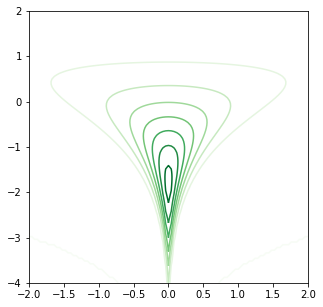

In [164]:
fig = plt.figure()
ax = fig.gca()
target_distribution = lambda x : np.exp(log_density(x,t))
plot_isocontours(ax, target_distribution)

Now we can approximiate this (true) posterior with a diagonal Gaussian distribution. This means $\mu$  and $\log(\sigma)$ are now independent from each other.

In [165]:
def black_box_variational_inference(logprob, D, num_samples):
    """Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557"""

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std

    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params

In [166]:
# Build variational objective.
objective, gradient, unpack_params = \
    black_box_variational_inference(log_density, D, num_samples=2000)

Optimizing variational parameters...
Iteration 0 lower bound -12.273217615146823
ax: 112047694960


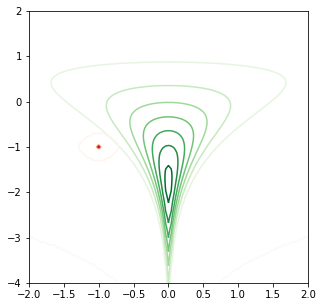

Iteration 100 lower bound -0.7660983263317891
ax: 112047694960


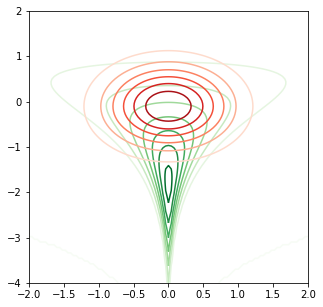

Iteration 200 lower bound -0.7312264002592777
ax: 112047694960


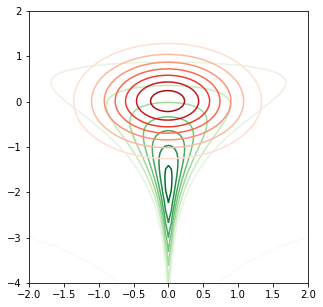

Iteration 300 lower bound -0.7948001233545641
ax: 112047694960


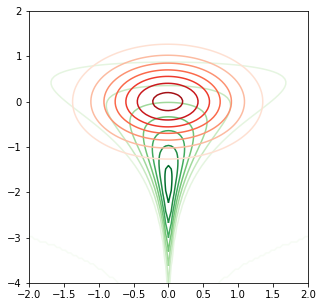

Iteration 400 lower bound -0.7371141405871409
ax: 112047694960


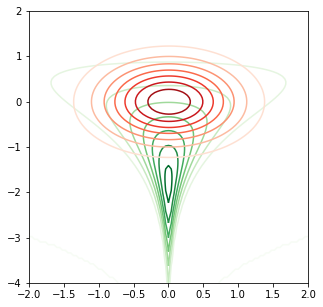

Iteration 500 lower bound -0.7497629664628018
ax: 112047694960


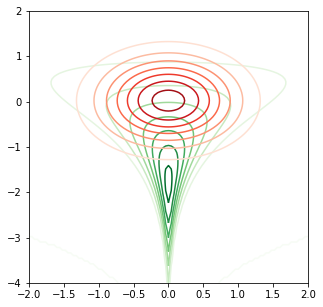

Iteration 600 lower bound -0.7204805786081296
ax: 112047694960


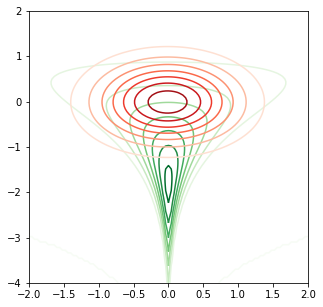

Iteration 700 lower bound -0.7415078878239902
ax: 112047694960


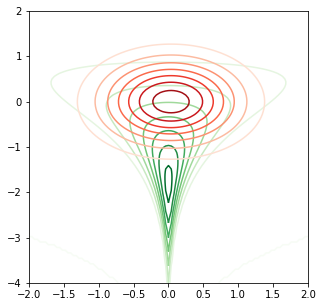

Iteration 800 lower bound -0.8126491843739001
ax: 112047694960


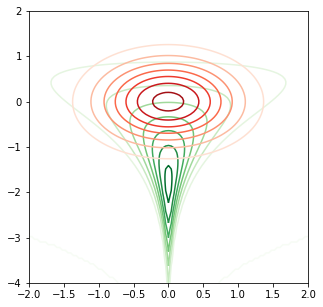

Iteration 900 lower bound -0.7812357661965417
ax: 112047694960


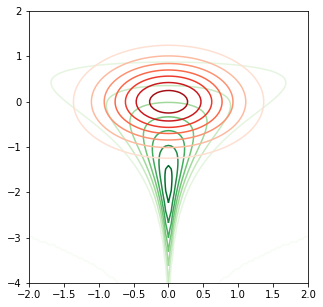

Iteration 1000 lower bound -0.7619004199238093
ax: 112047694960


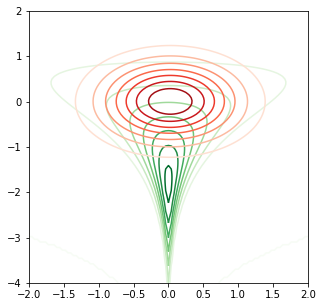

Iteration 1100 lower bound -0.7981702993707325
ax: 112047694960


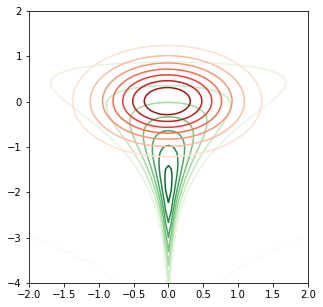

Iteration 1200 lower bound -0.793125796510064
ax: 112047694960


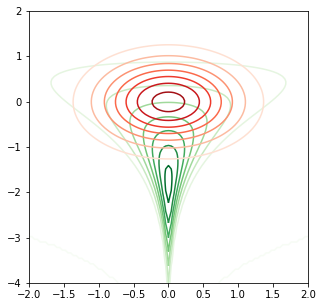

Iteration 1300 lower bound -0.8051084670736492
ax: 112047694960


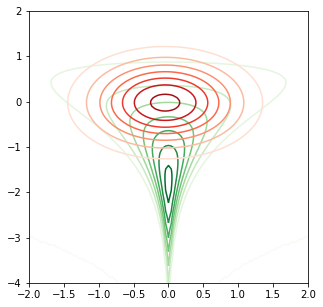

Iteration 1400 lower bound -0.7846769511873828
ax: 112047694960


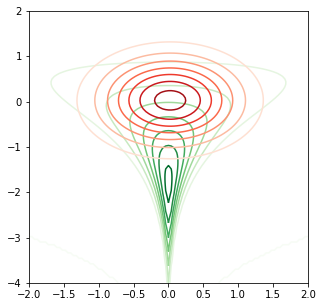

Iteration 1500 lower bound -0.7768003938297008
ax: 112047694960


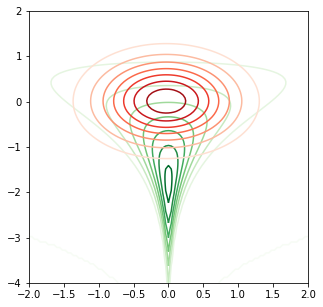

Iteration 1600 lower bound -0.7460954766100132
ax: 112047694960


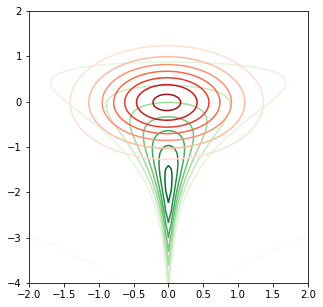

Iteration 1700 lower bound -0.8110453575237577
ax: 112047694960


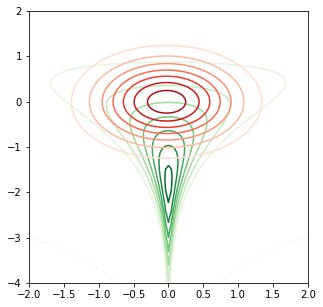

Iteration 1800 lower bound -0.8205455898073397
ax: 112047694960


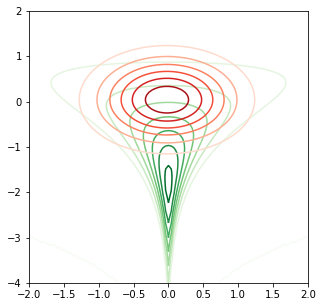

Iteration 1900 lower bound -0.760991919322529
ax: 112047694960


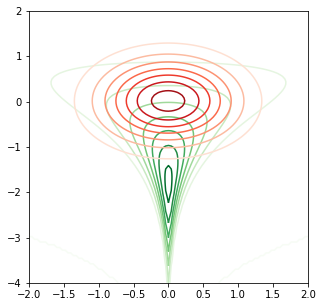

In [177]:
# Set up figure.
fig = plt.figure()
ax = plt.gca()
lower_bounds = []

def animate(params, t, g):
    if t%100 == 0:
        print("Iteration {} lower bound {}".format(t, -objective(params, t)))
        lower_bounds.append(-objective(params, t))
        target_distribution = lambda x : np.exp(log_density(x, t))
        print('ax:', id(ax))
        plot_isocontours(plt.gca(), target_distribution)

        mean, log_std = unpack_params(params)
        variational_contour = lambda x: mvn.pdf(x, mean, np.diag(np.exp(2*log_std)))
        plot_isocontours(plt.gca(), variational_contour, cmap='Reds')
        
        plt.pause(1.0/30.0)

print("Optimizing variational parameters...")
init_mean    = -1 * np.ones(D)
init_log_std = -5 * np.ones(D)
init_var_params = np.concatenate([init_mean, init_log_std])
variational_params = adam(gradient, init_var_params, step_size=0.1, num_iters=2000, callback=animate)

Climbing evidence lower bounds

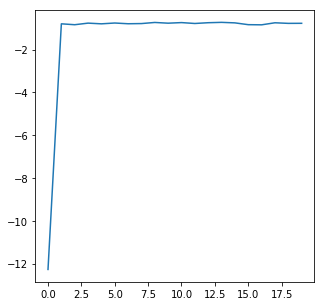

In [178]:
plt.plot(lower_bounds)

# References

1. [Five lines of Python code for automatic inference methods](https://www.cs.toronto.edu/~duvenaud/papers/blackbox.pdf)
2. [Black-box VI](https://arxiv.org/abs/1401.0118)
3. [Local Reparametrization tricks] (https://arxiv.org/pdf/1506.02557.pdf)

# Appendix

### Automatic differentiation using Autograd

In [6]:
import autograd.numpy as np
from autograd import grad
from autograd import elementwise_grad as egrad
import matplotlib.pyplot as plt

Note that instead of ``import numpy as np`` we use ``import autograd.numpy as np``. This is a thinly wrapped numpy.

Let's us implement $f(x) = x^2$ and its derivative $df(x) = 2x$

In [7]:
def f(x):
    return np.square(x)

df = grad(f)
edf = egrad(f)  

In [8]:
egrad(f)(np.array([4., 3.], dtype=np.float))

array([8., 6.])

In [9]:
from autograd import elementwise_grad as egrad  # for functions that vectorize over inputs
import matplotlib.pyplot as plt


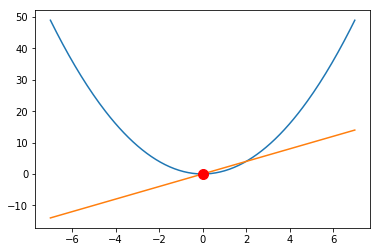

In [10]:
x = np.linspace(-7, 7, 200)
plt.plot(x, f(x), 
         x, edf(x))
plt.plot([0], [0], 'ro', markersize=10)# first  derivativ
plt.show()